In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, BatchNormalization

# fixed "Fail to find the dnn implementation." error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import pandas as pd
# plot pandas dates
from pandas.tseries import converter
pd.plotting.register_matplotlib_converters()

# interactive graphs on jupyter notebook
import mpld3

# 1. Data Extraction

In [2]:
filename = '../resources/data/4D_result_2018-01-01_2018-12-31.csv'
raw_data = pd.read_csv(filename, sep=';', dtype={'number': str})
# raw_data.info()

# 2. Data Transformation

In [3]:
transform_data = raw_data.copy()
transform_data.loc[transform_data['company_code'] == 'DMC', 'company_code'] = 'Da Ma Cai'
transform_data.loc[transform_data['company_code'] == 'MAG', 'company_code'] = 'Magnum'
transform_data.loc[transform_data['company_code'] == 'ST', 'company_code'] = 'Sports Toto'

transform_data.loc[transform_data['category'] == 'FST', 'category'] = '1st'
transform_data.loc[transform_data['category'] == 'SCD', 'category'] = '2nd'
transform_data.loc[transform_data['category'] == 'TRD', 'category'] = '3rd'
transform_data.loc[transform_data['category'] == 'SP', 'category'] = 'Special'
transform_data.loc[transform_data['category'] == 'CONS', 'category'] = 'Consolation'

# 3. Data Filtering

In [4]:
date_from = transform_data.min()['draw_date']
date_to = transform_data.max()['draw_date']

# date_from = '2019-01-01'
# date_to = '2019-07-31'

categories = ['1st', '2nd', '3rd', 'Special', 'Consolation']
price_count = sum(list(map(lambda x:
                           (x == '1st' or x == '2nd' or x == '3rd') and 1 or
                           (x == 'Special' or x == 'Consolation') and 10 or 0, categories
                          )))

company_code = 'Magnum'
data = transform_data[(transform_data['number'] != '----') &
                      (transform_data['company_code'] == company_code) &
                      (transform_data['draw_date'] >= date_from) &
                      (transform_data['draw_date'] <= date_to) &
                      (transform_data['category'].isin(categories))]
data = data.sort_values(by=['draw_date', 'company_code', 'category', 'position'])

# 4. Pre-Processing
### 4.1 Input & Target Preparation

In [5]:
period_arr = []
period_dict = data.groupby('draw_date').groups
for k in period_dict.keys():
    period_arr.append([data.loc[i]['number'] for i in period_dict.get(k)])

In [6]:
max_value = 9999
input_data = []
target_data = []

period_count = 5
for i, arr in enumerate(period_arr): 
    if i == len(period_arr) - period_count:
        break
    
    tmp_arr = []
    for n in range(period_count):
        tmp_arr.append(
            list(filter(lambda x: x[0] == i+n, enumerate(period_arr)))[0][1]
        )
    
    # Data Normalization
    input_data.append(
        [[float(n) / max_value for n in tmp_arr2] for tmp_arr2 in tmp_arr]
    )
    target_data.append(
        [float(n) / max_value for n in period_arr[i + period_count]]
    )

In [7]:
input_data = np.array(input_data, dtype=float)
target_data = np.array(target_data, dtype=float)

print('input_data.shape\t', input_data.shape)
print('target_data.shape\t', target_data.shape)

input_data.shape	 (176, 5, 23)
target_data.shape	 (176, 23)


### 4.2 Train & Test Preparation

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=4)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

# print('x_train:')
# print(x_train[:3])
# print('y_train:')
# print(y_train[:3])
# print()

# start_index = list(filter(lambda x: x[1][0] == '2644', enumerate(period_arr)))[0][0]
# print('input:')
# for n in range(period_count):
#     print(period_arr[start_index + n])
    
# print('target:')
# print(period_arr[start_index + period_count])

x_train.shape (140, 5, 23)
x_test.shape (36, 5, 23)


# 5. Neural Network
### 5.1 Model Definition

In [9]:
model = Sequential()
# model.add(CuDNNLSTM(price_count, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(price_count, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())

# model.add(CuDNNLSTM(price_count, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(price_count, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

model.summary()

W0818 15:38:16.753731  5640 deprecation.py:506] From C:\Users\WuQing\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 23)             4324      
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 23)             92        
_________________________________________________________________
lstm_1 (LSTM)                (None, 23)                4324      
_________________________________________________________________
batch_normalization_1 (Batch (None, 23)                92        
Total params: 8,832
Trainable params: 8,740
Non-trainable params: 92
_________________________________________________________________


### 5.2 Train Model

In [10]:
start_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))
end_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")

Train on 140 samples, validate on 36 samples


W0818 15:38:18.015803  5640 deprecation.py:323] From C:\Users\WuQing\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
140/140 [==============================] - 3s 25ms/sample - loss: 0.9202 - acc: 0.0429 - val_loss: 0.4928 - val_acc: 0.0000e+00
Epoch 2/500
140/140 [==============================] - 0s 864us/sample - loss: 0.8927 - acc: 0.0571 - val_loss: 0.4815 - val_acc: 0.0000e+00
Epoch 3/500
140/140 [==============================] - 0s 829us/sample - loss: 0.8712 - acc: 0.0357 - val_loss: 0.4700 - val_acc: 0.0000e+00
Epoch 4/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.8458 - acc: 0.0571 - val_loss: 0.4587 - val_acc: 0.0000e+00
Epoch 5/500
140/140 [==============================] - 0s 821us/sample - loss: 0.8213 - acc: 0.0571 - val_loss: 0.4484 - val_acc: 0.0000e+00
Epoch 6/500
140/140 [==============================] - 0s 936us/sample - loss: 0.8009 - acc: 0.0571 - val_loss: 0.4395 - val_acc: 0.0000e+00
Epoch 7/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.7787 - acc: 0.0643 - val_loss: 0.4316 - val_acc: 0.0000e+00
Epoch 8/500
140/14

140/140 [==============================] - 0s 850us/sample - loss: 0.2667 - acc: 0.0786 - val_loss: 0.2779 - val_acc: 0.0000e+00
Epoch 60/500
140/140 [==============================] - 0s 893us/sample - loss: 0.2638 - acc: 0.0857 - val_loss: 0.2771 - val_acc: 0.0000e+00
Epoch 61/500
140/140 [==============================] - 0s 786us/sample - loss: 0.2617 - acc: 0.1000 - val_loss: 0.2759 - val_acc: 0.0000e+00
Epoch 62/500
140/140 [==============================] - 0s 743us/sample - loss: 0.2607 - acc: 0.0857 - val_loss: 0.2745 - val_acc: 0.0000e+00
Epoch 63/500
140/140 [==============================] - 0s 771us/sample - loss: 0.2589 - acc: 0.0929 - val_loss: 0.2735 - val_acc: 0.0000e+00
Epoch 64/500
140/140 [==============================] - 0s 757us/sample - loss: 0.2564 - acc: 0.0786 - val_loss: 0.2731 - val_acc: 0.0000e+00
Epoch 65/500
140/140 [==============================] - 0s 821us/sample - loss: 0.2538 - acc: 0.1000 - val_loss: 0.2733 - val_acc: 0.0000e+00
Epoch 66/500
140/14

140/140 [==============================] - 0s 1ms/sample - loss: 0.2012 - acc: 0.1500 - val_loss: 0.2663 - val_acc: 0.0278
Epoch 118/500
140/140 [==============================] - 0s 2ms/sample - loss: 0.2029 - acc: 0.1286 - val_loss: 0.2657 - val_acc: 0.0833
Epoch 119/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.2027 - acc: 0.1571 - val_loss: 0.2674 - val_acc: 0.0556
Epoch 120/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.2001 - acc: 0.1571 - val_loss: 0.2699 - val_acc: 0.0556
Epoch 121/500
140/140 [==============================] - 0s 907us/sample - loss: 0.1997 - acc: 0.1857 - val_loss: 0.2686 - val_acc: 0.0556
Epoch 122/500
140/140 [==============================] - 0s 950us/sample - loss: 0.1998 - acc: 0.1357 - val_loss: 0.2670 - val_acc: 0.0556
Epoch 123/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.1998 - acc: 0.1857 - val_loss: 0.2681 - val_acc: 0.0556
Epoch 124/500
140/140 [============================

140/140 [==============================] - 0s 893us/sample - loss: 0.1784 - acc: 0.2214 - val_loss: 0.3154 - val_acc: 0.0278
Epoch 177/500
140/140 [==============================] - 0s 721us/sample - loss: 0.1769 - acc: 0.2214 - val_loss: 0.3175 - val_acc: 0.0278
Epoch 178/500
140/140 [==============================] - 0s 771us/sample - loss: 0.1773 - acc: 0.2429 - val_loss: 0.3156 - val_acc: 0.1111
Epoch 179/500
140/140 [==============================] - 0s 879us/sample - loss: 0.1773 - acc: 0.2643 - val_loss: 0.3129 - val_acc: 0.0833
Epoch 180/500
140/140 [==============================] - 0s 836us/sample - loss: 0.1764 - acc: 0.2643 - val_loss: 0.3118 - val_acc: 0.1111
Epoch 181/500
140/140 [==============================] - 0s 836us/sample - loss: 0.1784 - acc: 0.2000 - val_loss: 0.3186 - val_acc: 0.0556
Epoch 182/500
140/140 [==============================] - 0s 886us/sample - loss: 0.1773 - acc: 0.2786 - val_loss: 0.3249 - val_acc: 0.0833
Epoch 183/500
140/140 [==================

140/140 [==============================] - 0s 1ms/sample - loss: 0.1640 - acc: 0.2857 - val_loss: 0.3263 - val_acc: 0.0833
Epoch 236/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.1635 - acc: 0.3000 - val_loss: 0.3272 - val_acc: 0.1111
Epoch 237/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.1630 - acc: 0.3214 - val_loss: 0.3325 - val_acc: 0.0556
Epoch 238/500
140/140 [==============================] - 0s 979us/sample - loss: 0.1618 - acc: 0.3500 - val_loss: 0.3277 - val_acc: 0.0556
Epoch 239/500
140/140 [==============================] - 0s 893us/sample - loss: 0.1599 - acc: 0.3286 - val_loss: 0.3302 - val_acc: 0.0833
Epoch 240/500
140/140 [==============================] - 0s 907us/sample - loss: 0.1619 - acc: 0.3143 - val_loss: 0.3343 - val_acc: 0.0833
Epoch 241/500
140/140 [==============================] - 0s 864us/sample - loss: 0.1620 - acc: 0.3429 - val_loss: 0.3368 - val_acc: 0.0833
Epoch 242/500
140/140 [========================

140/140 [==============================] - 0s 914us/sample - loss: 0.1478 - acc: 0.2714 - val_loss: 0.3350 - val_acc: 0.1111
Epoch 295/500
140/140 [==============================] - 0s 879us/sample - loss: 0.1509 - acc: 0.2929 - val_loss: 0.3312 - val_acc: 0.1111
Epoch 296/500
140/140 [==============================] - 0s 807us/sample - loss: 0.1487 - acc: 0.3143 - val_loss: 0.3370 - val_acc: 0.0556
Epoch 297/500
140/140 [==============================] - 0s 800us/sample - loss: 0.1473 - acc: 0.3143 - val_loss: 0.3378 - val_acc: 0.0278
Epoch 298/500
140/140 [==============================] - 0s 786us/sample - loss: 0.1504 - acc: 0.2786 - val_loss: 0.3281 - val_acc: 0.0833
Epoch 299/500
140/140 [==============================] - 0s 871us/sample - loss: 0.1501 - acc: 0.3286 - val_loss: 0.3327 - val_acc: 0.0556
Epoch 300/500
140/140 [==============================] - 0s 829us/sample - loss: 0.1505 - acc: 0.3143 - val_loss: 0.3350 - val_acc: 0.0833
Epoch 301/500
140/140 [==================

140/140 [==============================] - 0s 843us/sample - loss: 0.1384 - acc: 0.3143 - val_loss: 0.3389 - val_acc: 0.0556
Epoch 354/500
140/140 [==============================] - 0s 814us/sample - loss: 0.1430 - acc: 0.3071 - val_loss: 0.3424 - val_acc: 0.0556
Epoch 355/500
140/140 [==============================] - 0s 871us/sample - loss: 0.1399 - acc: 0.3571 - val_loss: 0.3457 - val_acc: 0.0833
Epoch 356/500
140/140 [==============================] - 0s 800us/sample - loss: 0.1419 - acc: 0.3071 - val_loss: 0.3468 - val_acc: 0.0556
Epoch 357/500
140/140 [==============================] - 0s 879us/sample - loss: 0.1392 - acc: 0.2857 - val_loss: 0.3376 - val_acc: 0.0556
Epoch 358/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.1395 - acc: 0.3571 - val_loss: 0.3376 - val_acc: 0.0833
Epoch 359/500
140/140 [==============================] - 0s 1ms/sample - loss: 0.1416 - acc: 0.3357 - val_loss: 0.3432 - val_acc: 0.0556
Epoch 360/500
140/140 [======================

140/140 [==============================] - 0s 979us/sample - loss: 0.1321 - acc: 0.3357 - val_loss: 0.3471 - val_acc: 0.0278
Epoch 412/500
140/140 [==============================] - 0s 764us/sample - loss: 0.1309 - acc: 0.3500 - val_loss: 0.3444 - val_acc: 0.0278
Epoch 413/500
140/140 [==============================] - 0s 786us/sample - loss: 0.1308 - acc: 0.3714 - val_loss: 0.3447 - val_acc: 0.0278
Epoch 414/500
140/140 [==============================] - 0s 764us/sample - loss: 0.1314 - acc: 0.4214 - val_loss: 0.3511 - val_acc: 0.0556
Epoch 415/500
140/140 [==============================] - 0s 800us/sample - loss: 0.1326 - acc: 0.3571 - val_loss: 0.3423 - val_acc: 0.0556
Epoch 416/500
140/140 [==============================] - 0s 836us/sample - loss: 0.1284 - acc: 0.3571 - val_loss: 0.3388 - val_acc: 0.0278
Epoch 417/500
140/140 [==============================] - 0s 814us/sample - loss: 0.1295 - acc: 0.3714 - val_loss: 0.3477 - val_acc: 0.0556
Epoch 418/500
140/140 [==================

Epoch 470/500
140/140 [==============================] - 0s 829us/sample - loss: 0.1259 - acc: 0.3929 - val_loss: 0.3501 - val_acc: 0.0833
Epoch 471/500
140/140 [==============================] - 0s 821us/sample - loss: 0.1283 - acc: 0.3214 - val_loss: 0.3545 - val_acc: 0.0556
Epoch 472/500
140/140 [==============================] - 0s 886us/sample - loss: 0.1213 - acc: 0.4286 - val_loss: 0.3502 - val_acc: 0.0278
Epoch 473/500
140/140 [==============================] - 0s 779us/sample - loss: 0.1268 - acc: 0.3857 - val_loss: 0.3447 - val_acc: 0.0278
Epoch 474/500
140/140 [==============================] - 0s 779us/sample - loss: 0.1251 - acc: 0.3500 - val_loss: 0.3483 - val_acc: 0.0000e+00
Epoch 475/500
140/140 [==============================] - 0s 836us/sample - loss: 0.1222 - acc: 0.4429 - val_loss: 0.3481 - val_acc: 0.0556
Epoch 476/500
140/140 [==============================] - 0s 843us/sample - loss: 0.1272 - acc: 0.3714 - val_loss: 0.3566 - val_acc: 0.0556
Epoch 477/500
140/140 [

### 5.3 Result Prediction

In [11]:
print(f'Train Start:\t{start_time}')
print(f'Train End:\t{end_time}')

results = model.predict(x_test)

print('results.shape', results.shape)
print('y_test.shape', y_test.shape)

Train Start:	2019-08-18 15:38:17.678784
Train End:	2019-08-18 15:39:28.154815
results.shape (36, 23)
y_test.shape (36, 23)


# 6. Result Visualization

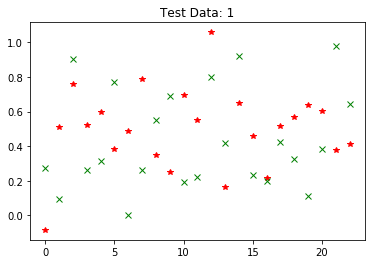

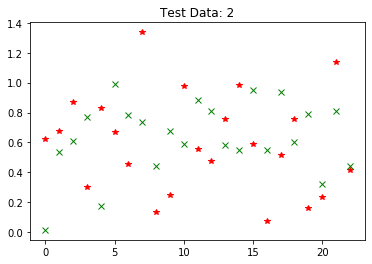

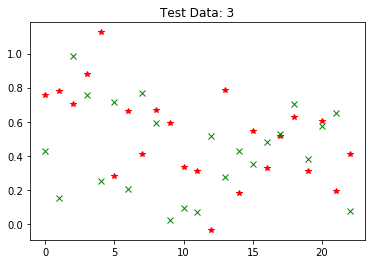

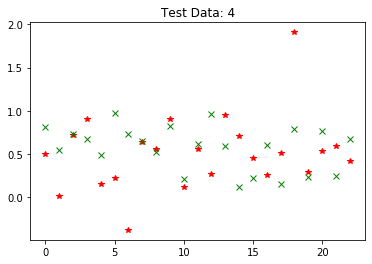

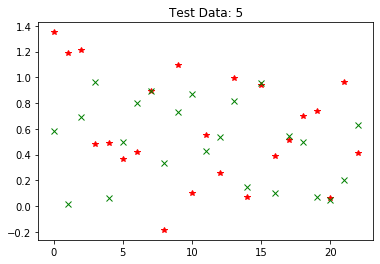

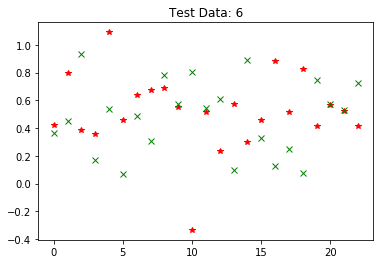

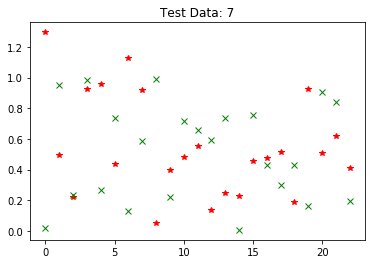

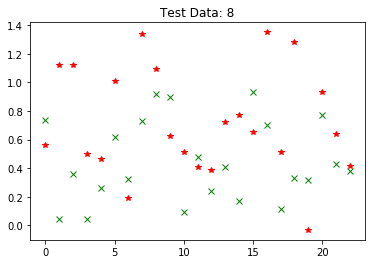

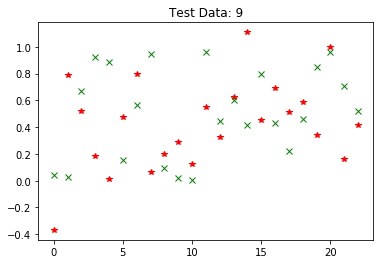

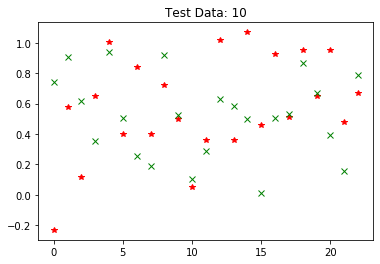

In [20]:
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [6, 4]

for i, arr in enumerate(y_test[:10]):
    plt.title(f'Test Data: {i+1}')
    plt.plot(range(results.shape[1]), results[i], c='r', marker='*', ls='none')
    plt.plot(range(results.shape[1]), arr, c='g', marker='x', ls='none')
    plt.show()

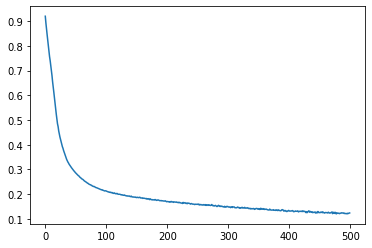

In [21]:
plt.plot(history.history['loss'])
plt.show()